# Segmentation Using Snakes

**11/23/2025**

In [222]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# for reading in images: 
import skimage.data as data
from skimage.io import imread 
from skimage.filters import threshold_otsu, gaussian

# for doing segmentation

import skimage.segmentation as seg 

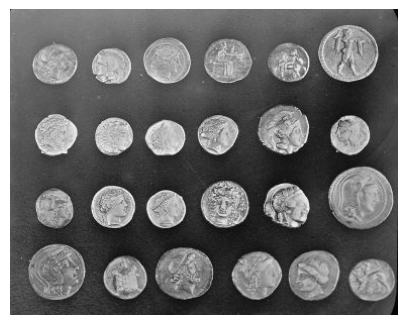

In [2]:
coinIm = data.coins()

plt.figure(figsize = (5,5))
plt.imshow(coinIm, 'gray')
plt.axis('off')
plt.show()

_Let's try using Snakes to segment on these coins._

In [3]:
# use to create contours for initial snakes
# didn't work well, so tried other things but wanted to keep this function regardless
def circle_points(resolution, center, radius):
    """Generate points defining a circle on an image."""
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [55,45], 22)[:-1]

# snake = seg.active_contour(coinIm, points)

# plt.imshow(coinIm)
# plt.plot(points[:, 0], points[:, 1], '--r', lw=3)
# plt.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

snake = seg.active_contour(
    gaussian(coinIm, sigma=3, preserve_range=False),
    init,
    alpha=0.015,
    beta=10,
    gamma=0.001,
)

_Well that looks terrible, could we try using the gradient approach from Hw 8?_

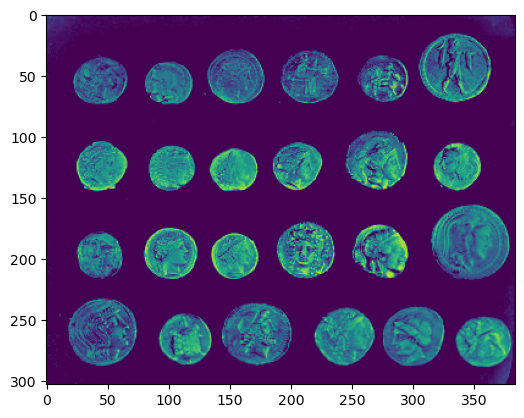

In [4]:
# cleaning up the images: 

# smooth with gaussian then take otsu: 
sigma = 35


coinGauss = np.clip(coinIm - gaussian(coinIm, sigma = sigma, preserve_range = True), 0, None)
coinGauss *= 255 / np.max(coinGauss)
coinThresh = coinGauss > threshold_otsu(coinGauss)

plt.imshow(coinGauss)

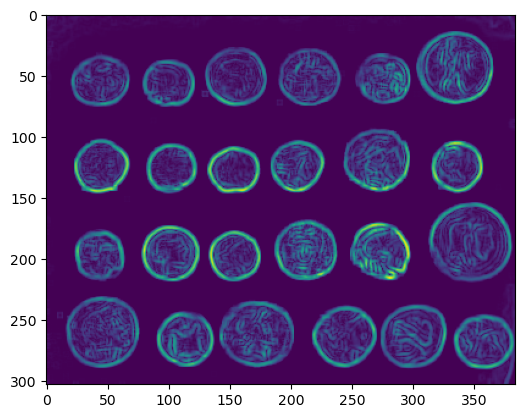

In [5]:
# setting up the gradients: 

from skimage import measure as skmeasure
from scipy import ndimage

x = np.arange(-2,3)[::-1] # reverse so negative numbers are last

sobelX, sobelY = np.meshgrid(x,x)

gradX = ndimage.convolve(input = coinGauss, weights = sobelX, mode = 'nearest')
gradY = ndimage.convolve(input = coinGauss, weights = sobelY, mode = 'nearest')

coinGrad = np.sqrt(gradX **2 + gradY ** 2)
plt.imshow(coinGrad)


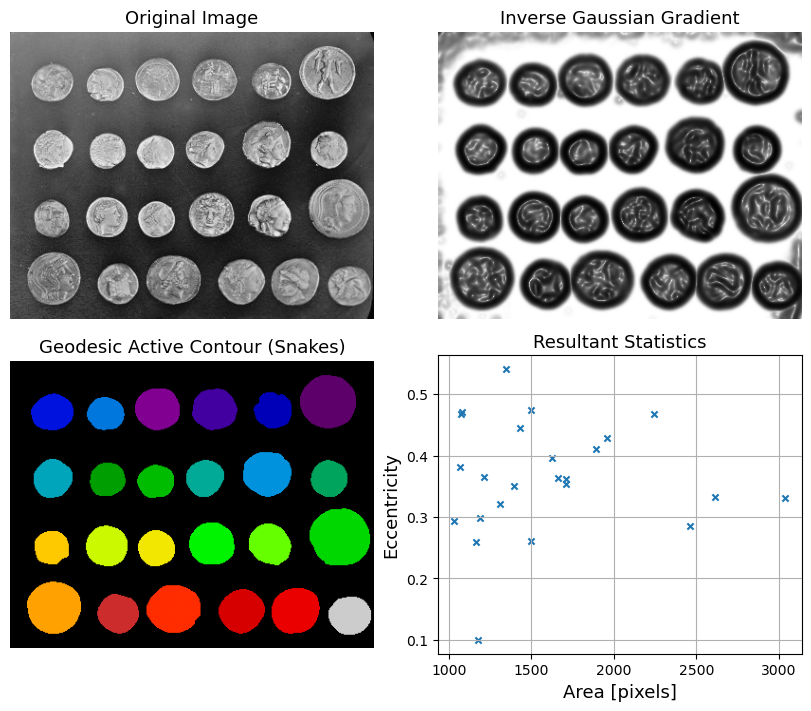

In [331]:
# following a snake tutorial: 
alpha = 1.4
sigma = 2.5
coinG = seg.inverse_gaussian_gradient(coinGauss, alpha = alpha, sigma = sigma)

init_ls = np.zeros(coinIm.shape, dtype=np.int8)
init_ls[5:-5, 5:-5] = 1
ls = seg.morphological_geodesic_active_contour(
    coinG,
    num_iter=200,
    init_level_set=init_ls,
    smoothing=1,
    balloon=-1,
    threshold=0.45,
)

fig, ([ax1,ax2], [ax3,ax4]) = plt.subplots(2,2, figsize = (8,7), layout = 'constrained')
fontSize = 13

ax1.imshow(coinIm, 'gray')
ax1.set_title('Original Image', fontsize = fontSize)
ax2.imshow(coinG, 'gray')
ax2.set_title(f'Inverse Gaussian Gradient', fontsize = fontSize)


ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# get labels for segmentation statistics 
labels = skmeasure.label(ls)
stats = skmeasure.regionprops(labels)

area = [stats[i].area for i in range(len(stats))]
ecc = [stats[i].eccentricity for i in range(len(stats))]


ax3.imshow(labels, 'nipy_spectral')
ax3.set_title('Geodesic Active Contour (Snakes)', fontsize = fontSize)
ax4.scatter(area, ecc, marker = 'x', s = 20)
ax4.set_xlabel('Area [pixels]', fontsize = fontSize)
ax4.set_ylabel('Eccentricity', fontsize = fontSize)
# ax4.set_xscale('log')
ax4.set_title('Resultant Statistics', fontsize = fontSize)
ax4.grid()

plt.savefig('snakesCoins.png')

plt.show()



_this method works best for images with clear regions of dark and light as opposed to images with strong borders. The geodesic active contour (snake) works by finding borders between regions of light and dark pixels, so the clearer this deviation, the better the segmentation. The $\alpha$ and $\sigma$ values were determined through guess and check._


_The next step is to try this on different images in the skimage.data library to see if we can generalize this to arbitrary images and try to determine the best sigma and alpha values, and if needing more sophisticated methods, try to find the best parameters such as threshold, smoothing, etc. . . in the geodesic function as well._

_The next thing I want to do is see if I can create an aritrary function that will determine the best parameters. For this, I want to see if there is a measurement property of some sort or a parameter that we can minimize?_

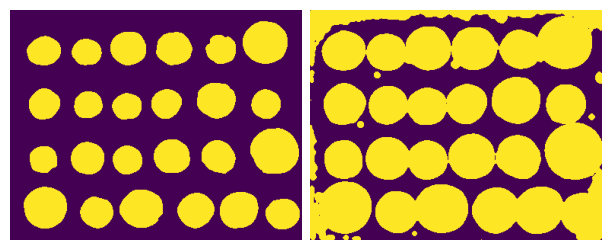

In [361]:


def snakes(im, alpha = 1.4, sigma =2.5, ls_boundary = 10):
    '''run a geodesic active contour on IM.
    IM should be pre-processed and ready to be countoured.
    ALPHA: determines the steepness of the inversion 
            for the gaussian gradient.
    SIGMA: standard deviation of gaussian kernel to use 
            for the gradient calculations'''
    b = ls_boundary # thickness of boundary for initial level set 
    imG = (seg.inverse_gaussian_gradient(im, 
                                alpha = alpha, sigma = sigma))
    init_ls = np.zeros(im.shape, dtype=np.int8)
    init_ls[b:-b, b:-b] = 1
    ls = seg.morphological_geodesic_active_contour(
        imG, num_iter=200, init_level_set= init_ls,
        smoothing=1, balloon=-1,threshold=0.45,
    )
    return ls



def snakesChanVese(im, alpha = 60, sigma = 2, ls_boundary = 10, manual_levelset = 'False', init_ls = 'frame'):
    '''run a geodesic active contour on IM.
    IM should be pre-processed and ready to be countoured.
    ALPHA: determines the steepness of the inversion for the gaussian gradient.
    SIGMA: standard deviation of gaussian kernel to use for the gradient calculations'''
    b = ls_boundary # thickness of boundary for initial level set 
    imG = seg.inverse_gaussian_gradient(im, alpha = alpha, sigma = sigma)
    if manual_levelset == 'False': 
        init_ls = np.zeros(im.shape, dtype=np.int8)
        init_ls[b:-b, b:-b] = 1
    ls = seg.morphological_chan_vese(
        imG, 
        num_iter=200, 
        init_level_set=init_ls, 
        smoothing=1, 
        # iter_callback=callback
    )
    return ls

alpha = 1.4
sigma = 2.5
checker = seg.checkerboard_level_set(coinIm.shape, square_size = 6)
coinSnakesGAC = snakes(coinGauss, ls_boundary = 5, alpha = alpha, sigma = sigma)
coinSnakesVC = snakesChanVese(coinGauss, manual_levelset = 'True', init_ls = checker) 


fig, (ax1,ax2) = plt.subplots(1,2,figsize = (6,3), layout = 'constrained')
ax1.imshow(coinSnakesGAC)
ax2.imshow(coinSnakesVC)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()


_I've noticed that this method is really finicky when it comes to the alpha value, so finding the best alpha value will be critical for doing the best segmentation._

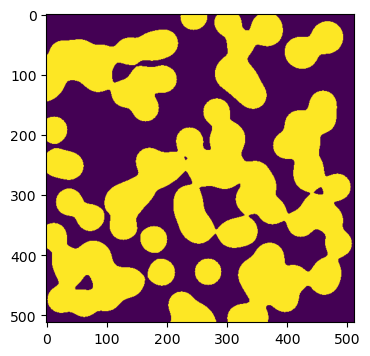

In [112]:
# let's try another image

plt.figure(figsize = (4,4))
plt.imshow(data.binary_blobs().astype(int))

_We can generate "binary blobs" and turn ths into arbitrary images, which could be a good way to create data for a machine learning approach to segmentation._

/var/folders/4w/cx6n90fj0tj22vn7nyt4jg5w0000gn/T/ipykernel_19515/2917899300.py:13: RuntimeWarning: invalid value encountered in divide
  psf = np.where(np.abs(v) > 0, 4 * (j1(v)/v)**2, 1); # deal with div 0


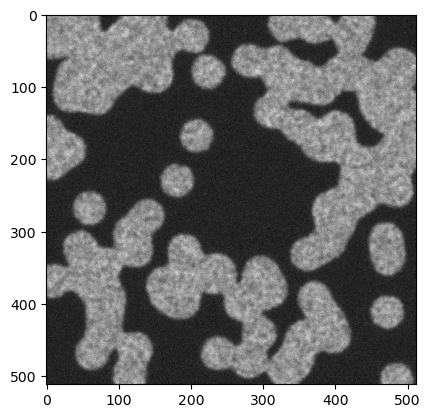

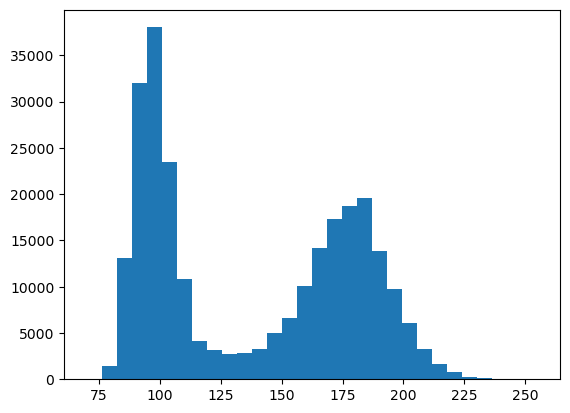

In [192]:
from scipy.special import j1
def PSF(N = 25, lam = 0.51, NA = 0.5, scale = 0.1, loc = (0,0)):
    # make meshgrid centered at 0
    xloc, yloc = loc
    x,y = np.arange(-(N//2), N//2 +1) - xloc, np.arange(-(N//2), N//2 +1) + yloc 
    xv,yv = np.meshgrid(x,y)

    #scale to microns and solve for v
    d = np.sqrt(xv**2 + yv**2) # distances matrix
    r = d * scale # scaled to microns/pixel
    v = 2 * np.pi /lam * NA * r 
    # evaluate psf
    psf = np.where(np.abs(v) > 0, 4 * (j1(v)/v)**2, 1); # deal with div 0
    return psf / np.sum(psf) # normalize
 

def generate_image(N = 512, volume_fraction = 0.5, b = 60):
    '''generate a blob image that has been convolved with a PSF and then add in noise
    N = size of image in x and y such that image.shape = (N,N)
    volume_fraction = percentage of image that is a "blob"
    b = mean background value'''
    labels = data.binary_blobs(length = N, volume_fraction = volume_fraction).astype(int)
    psf = PSF() 
    im = np.random.poisson(labels) * 100 + 60
    im = ndimage.convolve(im, psf) # convolve with PSF 
    im = np.random.poisson(im) # add in poisson noise 
    im = im + np.random.poisson(b)
    im = (im* 255/np.max(im)).astype(int)
    return im, labels



plt.imshow(generate_image()[0], 'gray')
plt.show()
plt.hist(generate_image()[0].flatten(), bins = 30);

/var/folders/4w/cx6n90fj0tj22vn7nyt4jg5w0000gn/T/ipykernel_19515/2917899300.py:13: RuntimeWarning: invalid value encountered in divide
  psf = np.where(np.abs(v) > 0, 4 * (j1(v)/v)**2, 1); # deal with div 0


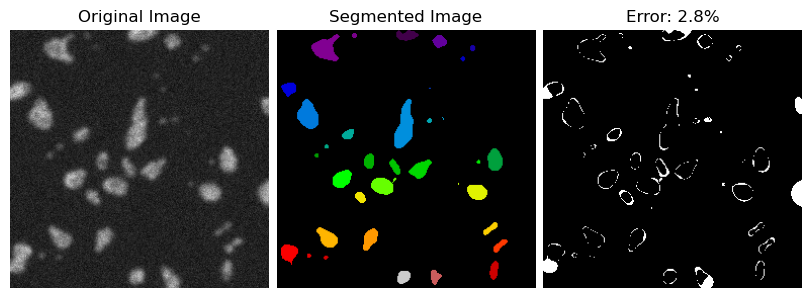

In [377]:
# trying on our blob: 
N = 256
sizeSquares = 4
blob, blobLabels = generate_image(N = N, volume_fraction = 0.1);
sigma = 50

#i wanna try checkerboard level set 

checker = seg.checkerboard_level_set((N,N), square_size = sizeSquares)

blobGauss = (np.clip(blob - gaussian(blob, sigma = sigma, preserve_range = True), 0, None))
blobGauss = blobGauss * 255 / np.max(blobGauss)
snakeBlob = snakes(blobGauss, alpha = 1.5, sigma = 1.5, ls_boundary = 3)
# snakeBlob = snakesChanVese(blobGauss, init_ls = checker, manual_levelset = 'True')


# compare to the accuracy of the original binary image: 
blobErr = np.abs(blobLabels - snakeBlob) # find pixels that were characterized wrong
err = np.mean(blobErr)
labelsFound = skmeasure.label(snakeBlob)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (8,3), layout= 'constrained')

# plt.suptitle('Morphological Snakes', fontsize = 13)

ax1.imshow(blob, 'gray')
ax2.imshow(labelsFound, 'nipy_spectral')

ax1.set_title('Original Image')
ax2.set_title('Segmented Image')
ax3.imshow(blobErr, 'gray')

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

ax3.set_title(f'Error: {round(err * 100, 1)}%')
plt.savefig('mophologicalSnakesDemo.png')
plt.show()

In [397]:
#  I want to see how accurate this is depending on the fill fraction! 

from skimage.metrics import adapted_rand_error, variation_of_information

from skimage.segmentation import mark_boundaries

In [479]:
# now to follow the guide in skimage: 

# true labels is found in the labels output of hte pblob

trueIm = skmeasure.label(blobLabels)

error, precision, recall = adapted_rand_error(trueIm, blobLabels)
splits, merges = variation_of_information(trueIm, blobLabels)


# plt.imshow(mark_boundaries(blob, blobLabels))
# plt.colorbar()
# plt.show()


def findErrors(fillVal):
    image, labels = generate_image(volume_fraction = fillVal)
    labels = skmeasure.label(labels)
    imGauss = (np.clip(image - gaussian(image, sigma = 50, preserve_range = True), 0, None))
    imGauss = imGauss * 255 / np.max(imGauss)
    snake = snakes(imGauss, alpha = 1.5, sigma = 1.5, ls_boundary = 3)
    snakeLabels = skmeasure.label(snake)
    error, precision, recall = adapted_rand_error(labels, snakeLabels)
    splits, merges = variation_of_information(labels, snakeLabels)
    return fillVal, error, precision, recall, splits, merges


    

In [467]:
# values to iterate over
fillVal = np.linspace(0.01, 0.99, 20)
errorVals = np.array(list(map(findErrors, fillVal)))

/var/folders/4w/cx6n90fj0tj22vn7nyt4jg5w0000gn/T/ipykernel_19515/2917899300.py:13: RuntimeWarning: invalid value encountered in divide
  psf = np.where(np.abs(v) > 0, 4 * (j1(v)/v)**2, 1); # deal with div 0


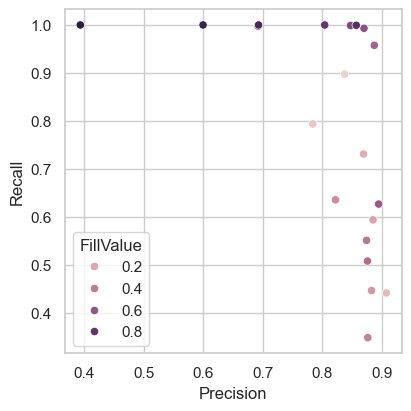

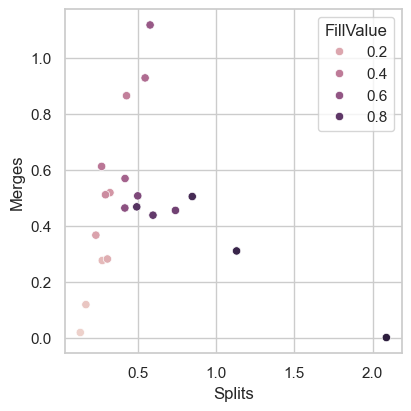

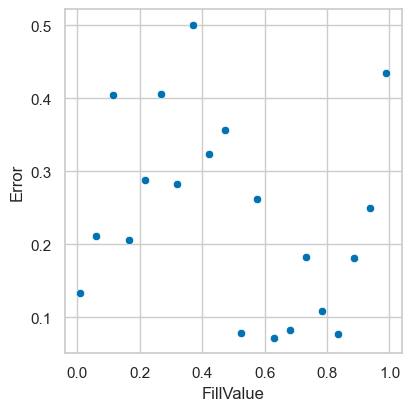

In [504]:
import pandas as pd
import seaborn as sns

headers = ['FillValue','Error','Precision','Recall','Splits','Merges']

errorData = pd.DataFrame(data = errorVals, columns = headers)

plt.figure(figsize = (4,4),layout = 'constrained')
sns.set_theme(palette = 'colorblind', style = 'whitegrid')
sns.scatterplot(data = errorData, x = 'Precision', y = 'Recall', hue = 'FillValue')
plt.savefig('precision_and_recall.png')
plt.show()

plt.figure(figsize = (4,4), layout = 'constrained')
sns.set_theme(palette = 'colorblind', style = 'whitegrid')
sns.scatterplot(data = errorData, x = 'Splits', y = 'Merges', hue = 'FillValue')
plt.savefig('splits_and_merges.png')
plt.show()

plt.figure(figsize = (4,4), layout = 'constrained')
sns.set_theme(palette = 'colorblind', style = 'whitegrid')
sns.scatterplot(data = errorData, x = 'FillValue', y = 'Error')
plt.show()

In [490]:
# let's test computational time for each of these: 
import time
Ns = np.arange(10,501,10).astype(int) # this is a lot of images!

def getTime(N):
    image, labels = generate_image(N)
    deltaT = []
    for _ in range(10):
        start = time.time()
        snakes(gaussian(image, sigma = N//10, preserve_range = True))
        end = time.time()
        deltaT.append(end - start)
        
    return np.mean(np.array(deltaT))


times = np.array(list(map(getTime, Ns)))  
                           

/var/folders/4w/cx6n90fj0tj22vn7nyt4jg5w0000gn/T/ipykernel_19515/2917899300.py:13: RuntimeWarning: invalid value encountered in divide
  psf = np.where(np.abs(v) > 0, 4 * (j1(v)/v)**2, 1); # deal with div 0


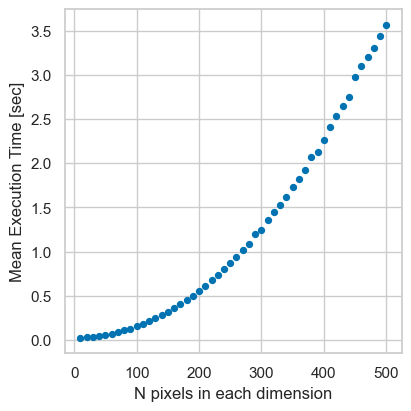

In [506]:
plt.figure(figsize = (4,4), layout = 'constrained')
plt.scatter(Ns, times, s = 18)
plt.ylabel('Mean Execution Time [sec]')
plt.xlabel('N pixels in each dimension')
plt.savefig('snakeTimes.png')
plt.show()